# AI - MLP Project

## Function output prediction

### Ahmad Salimi - 97106013

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.callbacks import LearningRateScheduler
from sklearn.preprocessing import MinMaxScaler
import inspect

In [3]:
class LossHistory(keras.callbacks.Callback):

    def __init__(self, learner):
        self.learner = learner

    def on_train_begin(self, logs={}):
        self.data = {'loss': [], 'lr': []}
    
    def on_epoch_end(self, batch, logs={}):
       self.data['loss'].append(logs.get('loss'))
       self.data['lr'].append(self.learner.lr)

In [54]:
class FunctionLearner:
    
    def __init__(self, function, data_size, train_domain_low, train_domain_high, neurons=[20, 20], noise_sigma=None):
        self.function = function
        self.feature_scaler = MinMaxScaler()
        self.target_scaler = MinMaxScaler()
        self.X, self.y = self.make_random_dataset(data_size, train_domain_low, train_domain_high, noise_sigma)
        self.model = self.create_model(neurons)
        self.lr = 0.01
        self.alpha = 0.9
    
    def get_feature_dimension(self):
        return len(inspect.signature(self.function).parameters)
    
    def make_random_dataset(self, size:int, low, high, noise_sigma):
        feature_shape = (size, self.get_feature_dimension())

        X = np.random.uniform(low, high, feature_shape)
        self.feature_scaler.fit(X)

        y = self.function(*X.T).reshape(size, 1)

        if noise_sigma:
            y += np.random.normal(scale=noise_sigma, size=(size, 1))

        self.target_scaler.fit(y)

        return X, y

    def step_decay(self, epoch):
        if epoch % 500 == 0:
            self.lr *= 0.9
        return self.lr
    
    def create_model(self, neurons):
        model = Sequential()
        model.add(Dense(neurons[0], input_dim=self.get_feature_dimension(), activation='relu', kernel_initializer='he_uniform'))
        model.add(Dense(neurons[0], activation='relu', kernel_initializer='he_uniform'))
        model.add(Dense(1))

        opt = keras.optimizers.adam(learning_rate=0.01)
        model.compile(optimizer=opt, loss='mse')
        return model

    def plot_axis(self, x, axis, title=None):
        plt.figure(figsize=(15, 10))

        if title:
            plt.title(title)
        
        plt.scatter(x[:, axis], self.predict(x).reshape(x.shape[0],) - self.function(*x.T), color='red', label='prediction error', s=5, zorder=1)
        plt.scatter(self.X[:, axis], self.y.reshape(self.X.shape[0],) - self.function(*self.X.T), color='green', label='train error', s=5, zorder=2)

        plt.grid()
        plt.legend()
    
    def plot_result(self, x, title=None, xlim=None, ylim=None):
        if self.get_feature_dimension() > 1:
            raise Exception("Cannot plot more than 2d")
        
        plt.figure(figsize=(15, 10))

        if title:
            plt.title(title)
        
        plt.scatter(*x.T, self.function(*x.T), color='skyblue', label='original', s=90, zorder=1)
        plt.scatter(*self.X.T, self.y, color='green', label='train data', s=50, zorder=2)
        plt.scatter(*x.T, self.predict(x), color='red', label='predicted', s=5, zorder=3)
        plt.grid()
        if xlim:
            plt.xlim(xlim)
        if ylim:
            plt.ylim(ylim)
        plt.legend()

    def plot_history(self, name, ylim=None):
        plt.figure(figsize=(15, 10))
        plt.plot(np.arange(len(self.loss_history.data[name])), self.loss_history.data[name], color='skyblue', label='name', linewidth=3, zorder=1)
        plt.grid()
        if ylim:
            plt.ylim(ylim)
        plt.legend()
    
    def learn(self, epochs):
        learning_rate = LearningRateScheduler(self.step_decay)
        self.loss_history = LossHistory(self)

        self.model.fit(
            self.feature_scaler.transform(self.X), 
            self.target_scaler.transform(self.y), 
            batch_size=10, epochs=epochs, 
            callbacks=[self.loss_history, learning_rate], 
            verbose=0, validation_split=0.1)

        return f'loss = {self.loss_history.data["loss"][-1]:.4e}'
    
    def mse(self, X, Y):
        return ((X - Y) ** 2).mean()

    def accuracy(self, X):
        prediction = self.predict(X)
        return self.mse(prediction, self.function(*X.T).reshape(prediction.shape))
    
    def predict(self, X):
        return self.target_scaler.inverse_transform(
            self.model.predict(
                self.feature_scaler.transform(X)))

$ \mathcal{f}(x) = \sin(x) $

In [ ]:
learner = FunctionLearner(function=lambda x: np.sin(x), data_size=100, train_domain_low=-10, train_domain_high=10)

In [ ]:
learner.learn(2000)

'loss = 1.7754e-03'

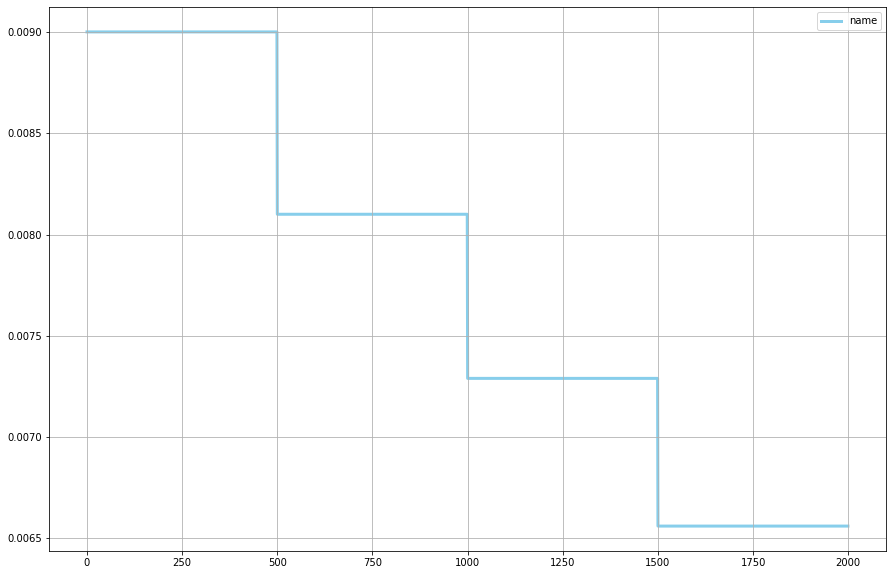

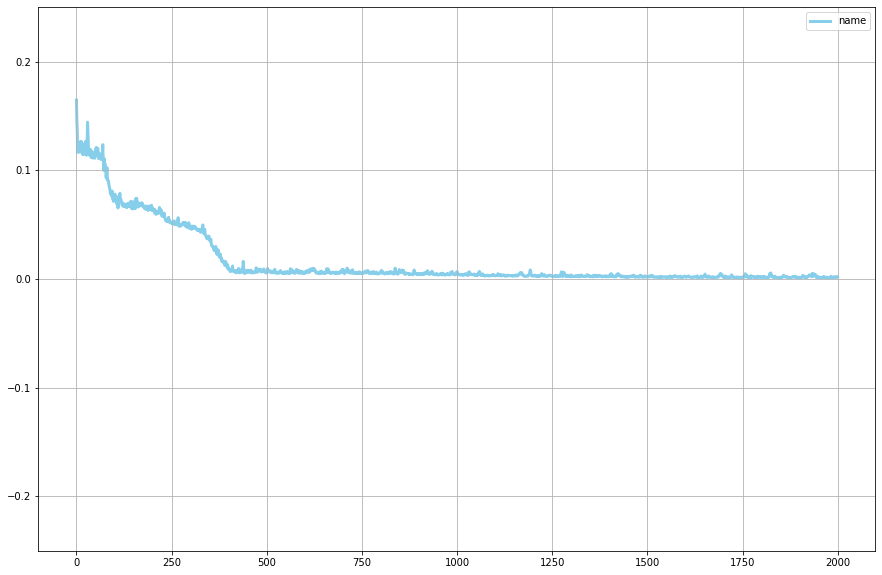

In [ ]:
learner.plot_history('lr')
learner.plot_history('loss', ylim=(-.25, .25))

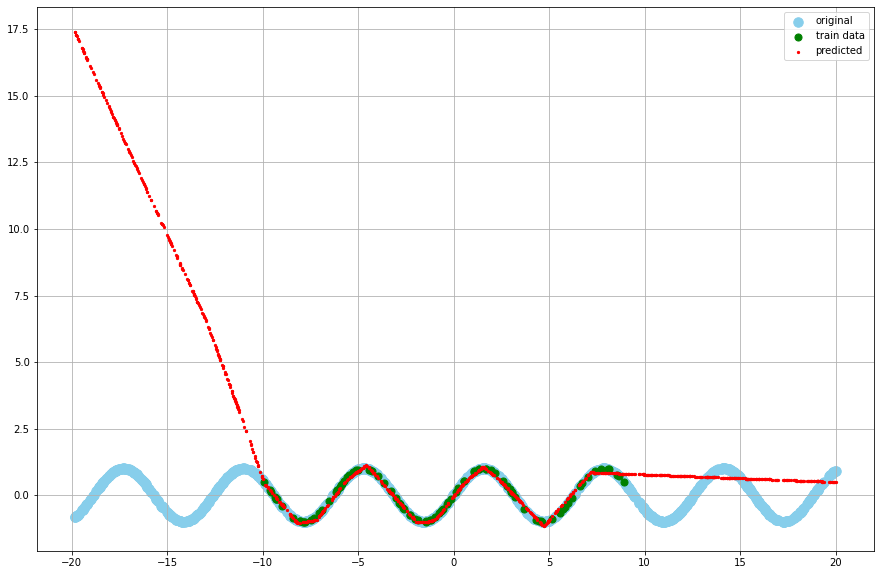

In [ ]:
learner.plot_result(np.random.uniform(-20, 20, (1000, 1)))

$ \mathcal{f}(x) = 50x^3 + 2500 $

In [ ]:
learner = FunctionLearner(function=lambda x: 50 * x ** 3 + 2500, data_size=100, train_domain_low=-10, train_domain_high=10)

In [ ]:
learner.learn(2000)

'loss = 2.0894e-05'

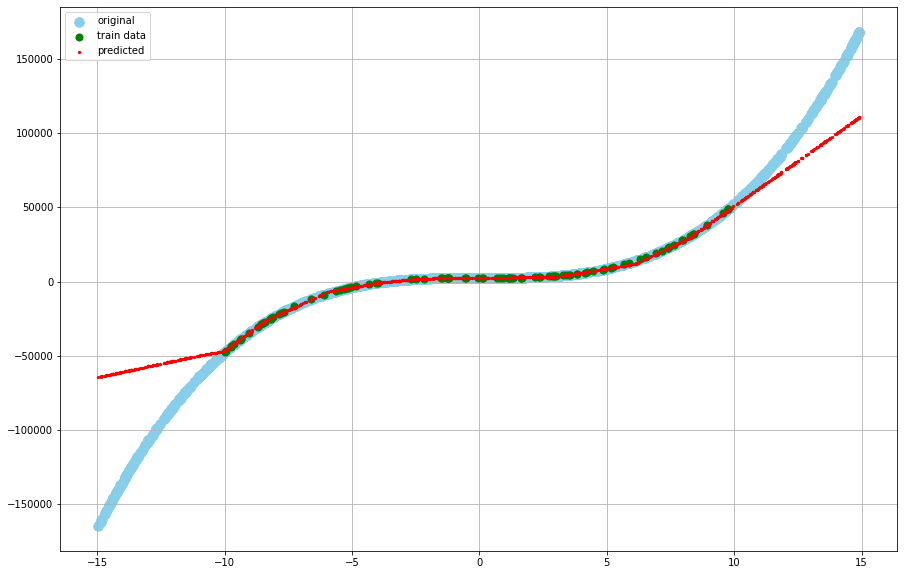

In [ ]:
learner.plot_result(np.random.uniform(-15, 15, (1000, 1)))

$ \mathcal{f}(x) = x^2\sin(x) $

In [ ]:
learner = FunctionLearner(function=lambda x: x ** 2 * np.sin(x), data_size=500, train_domain_low=-10, train_domain_high=10)

In [ ]:
learner.learn(2000)

'loss = 7.6110e-04'

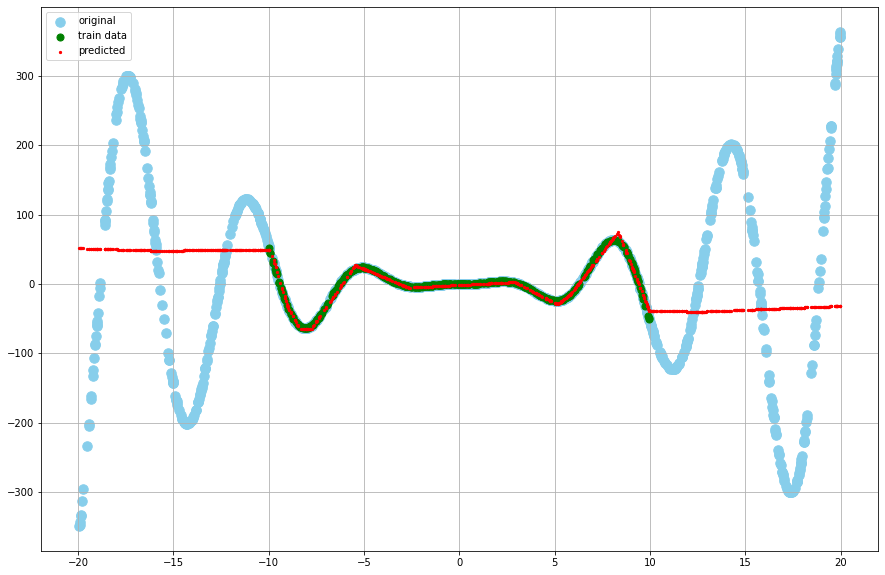

In [ ]:
learner.plot_result(np.random.uniform(-20, 20, (1000, 1)))

start training on noise 0.05
loss = 6.2985e-03
start training on noise 0.1
loss = 2.4956e-02
start training on noise 0.15000000000000002
loss = 2.7164e-02
start training on noise 0.2
loss = 2.7954e-02
start training on noise 0.25
loss = 4.7085e-03
start training on noise 0.3
loss = 8.8366e-03
start training on noise 0.35000000000000003
loss = 2.0051e-02
start training on noise 0.4
loss = 1.3687e-02
start training on noise 0.45
loss = 1.5345e-02


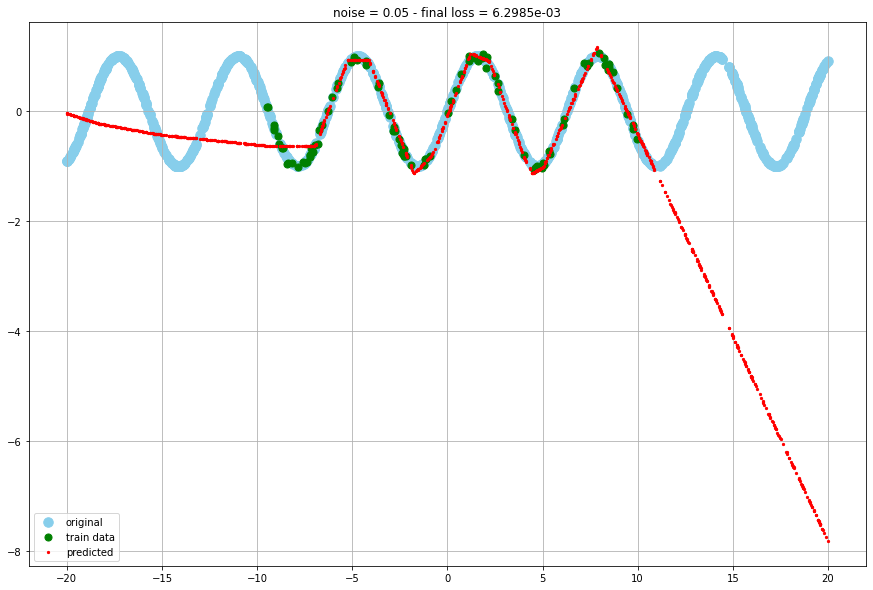

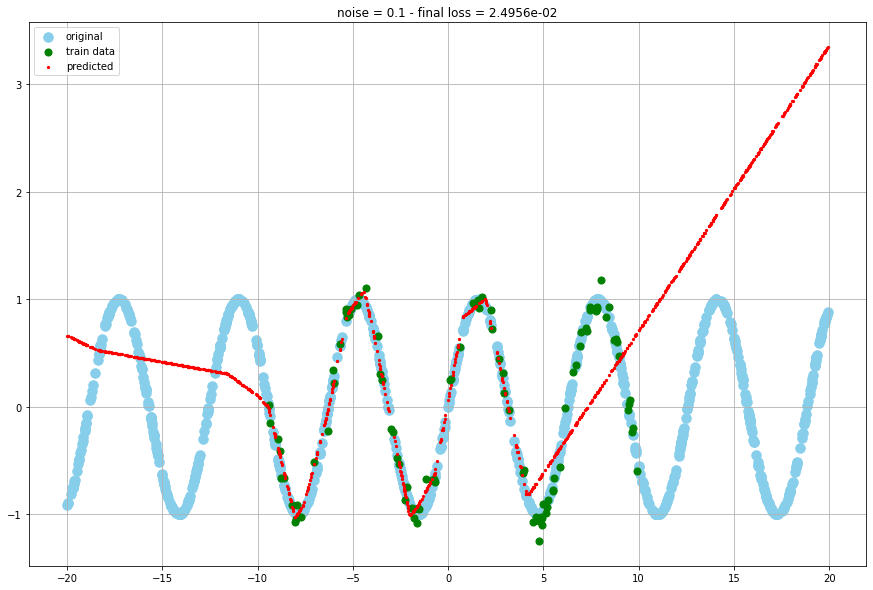

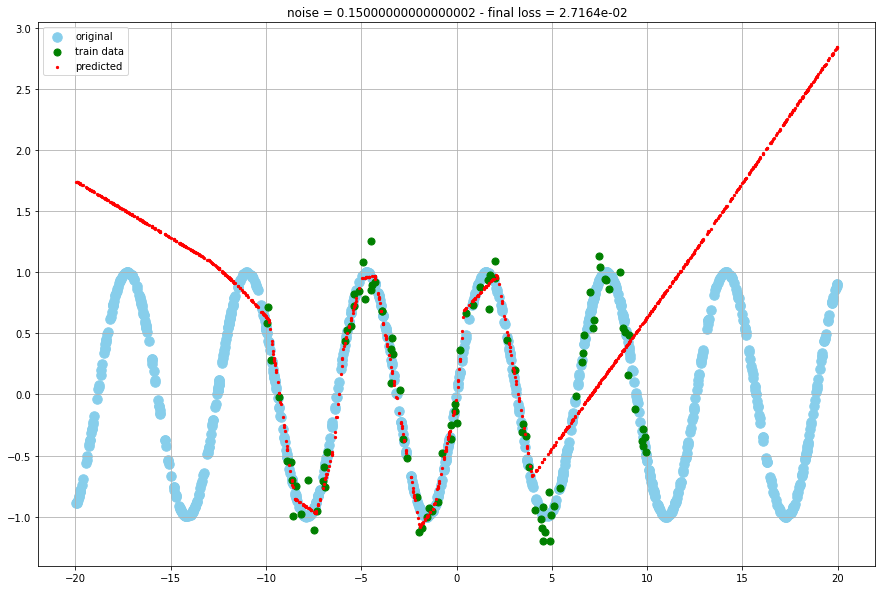

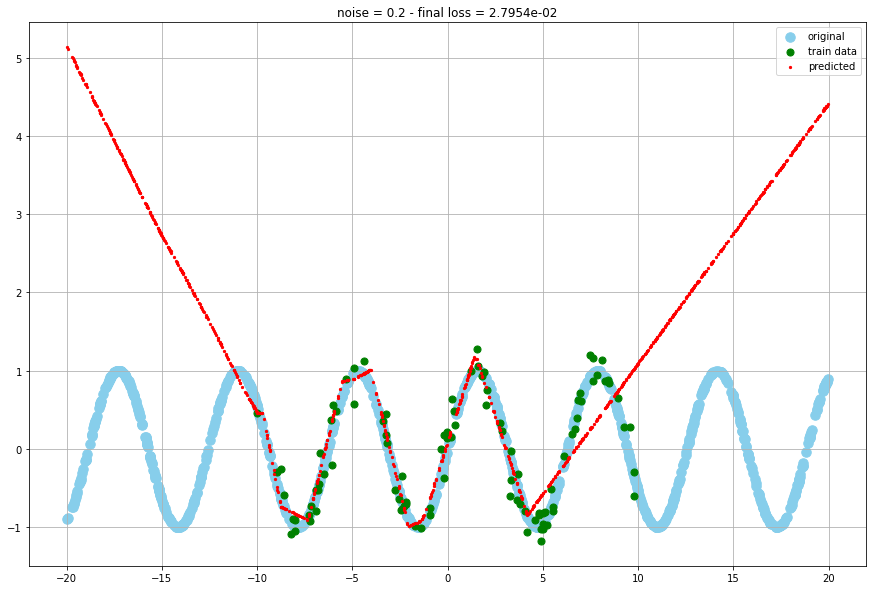

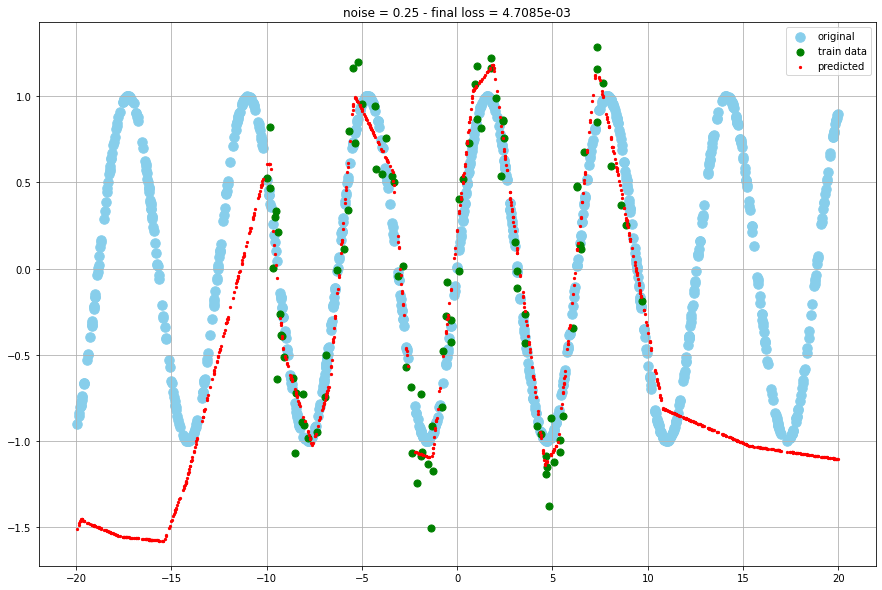

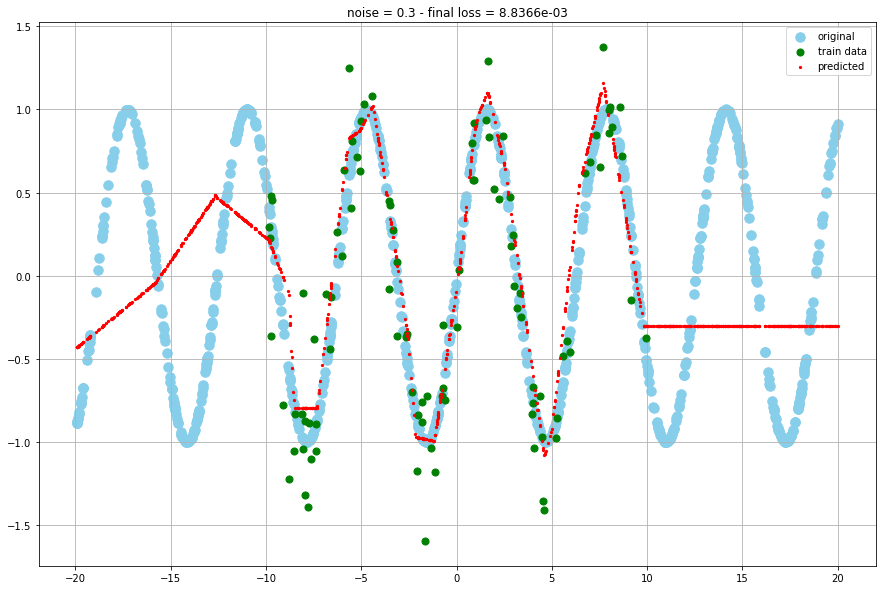

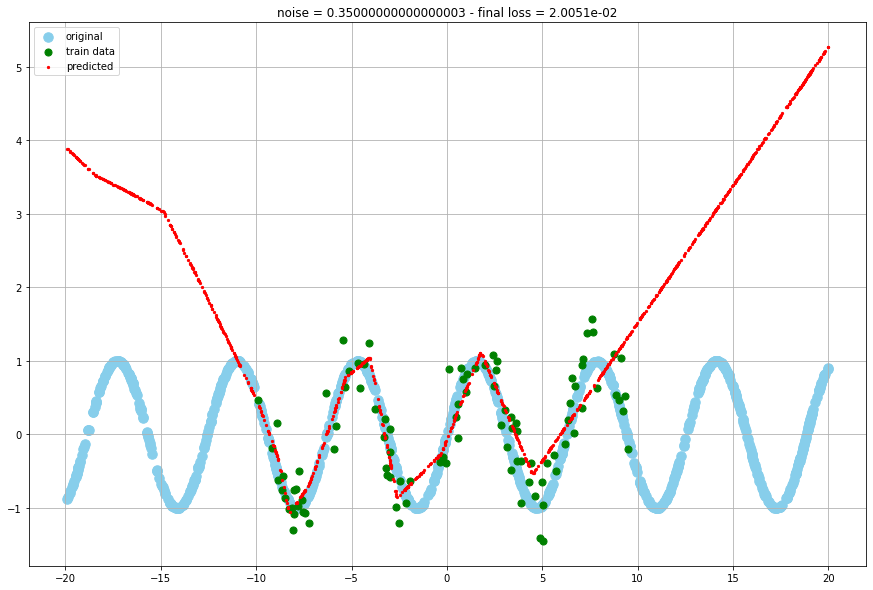

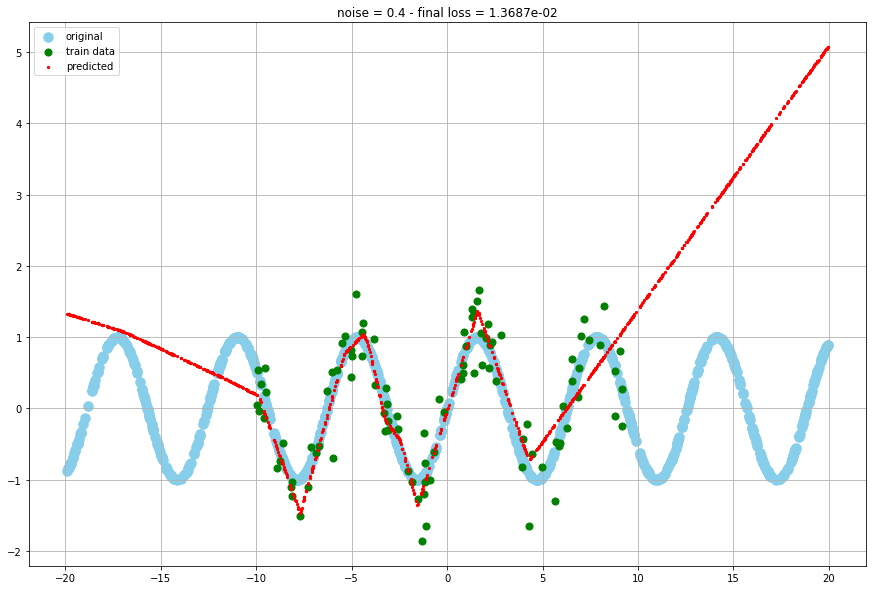

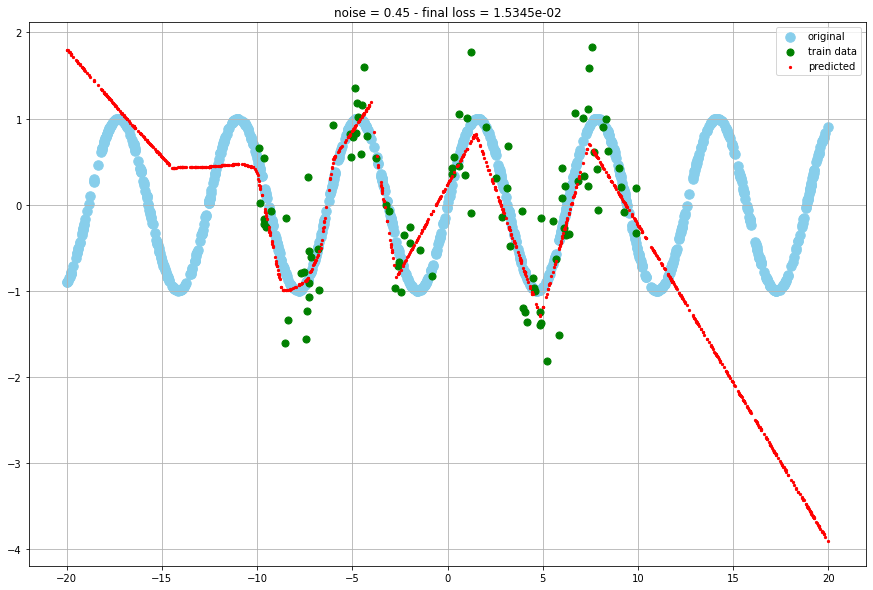

In [ ]:
for noise in np.arange(0.05, 0.5, 0.05):
    print(f'start training on noise {noise}')
    learner = FunctionLearner(function=lambda x: np.sin(x), data_size=500, train_domain_low=-10, train_domain_high=10, noise_sigma=noise)
    loss = learner.learn(4000)
    print(loss)
    learner.plot_result(np.random.uniform(-20, 20, (1000, 1)), f'noise = {noise} - final {loss}')

$ \mathcal{f}(x, y) = x^2 + y^3 - 3xy^2 $

In [60]:
learner = FunctionLearner(function=lambda x, y: x**2 + y**3 - 3*x*y**2 , data_size=500, train_domain_low=(-5, -5), train_domain_high=(5, 5), neurons=[32, 32])

In [61]:
learner.learn(2000)

'loss = 1.4244e-04'

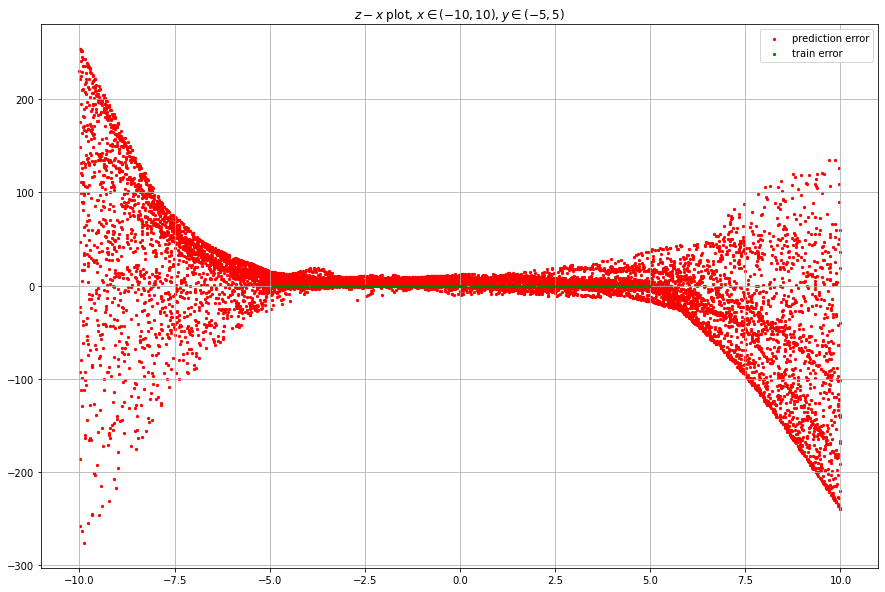

In [62]:
learner.plot_axis(np.random.uniform((-10, -5), (10, 5), (10000, 2)), 0, "$z-x$ plot, $x \\in (-10, 10), y \\in (-5, 5)$")

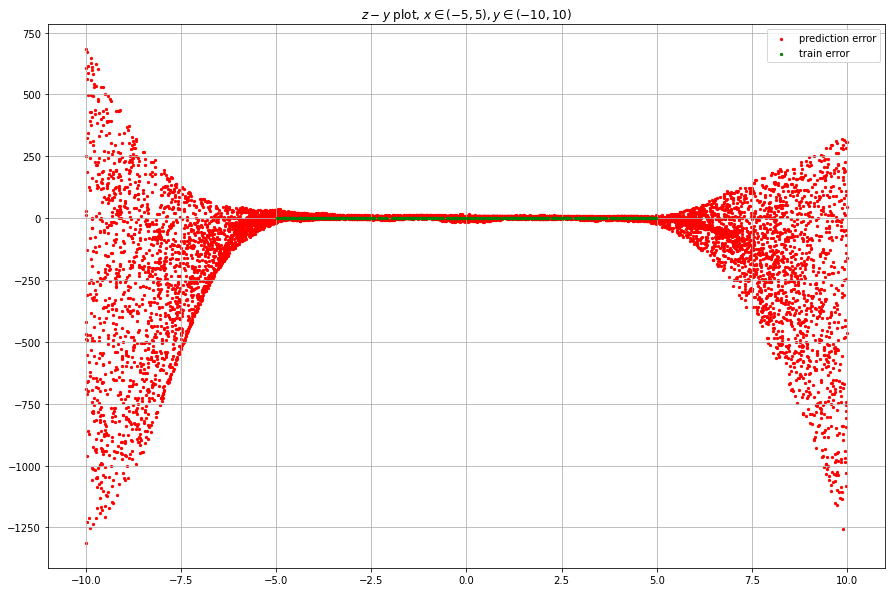

In [63]:
learner.plot_axis(np.random.uniform((-5, -10), (5, 10), (10000, 2)), 1, "$z-y$ plot, $x \\in (-5, 5), y \\in (-10, 10)$")

In [64]:
learner.accuracy(learner.X)

48.18865344838393

In [66]:
learner.accuracy(np.random.uniform((-10, -10), (10, 10), (10000, 2)))

185898.7209638536

$ \mathcal{f}(x, y, z) = x \log{y} - z^2 \sin(ye^x) $

In [87]:
learner = FunctionLearner(function=lambda x, y, z: x * np.log(y) - z ** 2 * np.sin(np.exp(x) * y), data_size=500, train_domain_low=(-5, 0, -5), train_domain_high=(5, 10, 5), neurons=[32, 64])

In [88]:
learner.learn(3000)

'loss = 5.8635e-03'

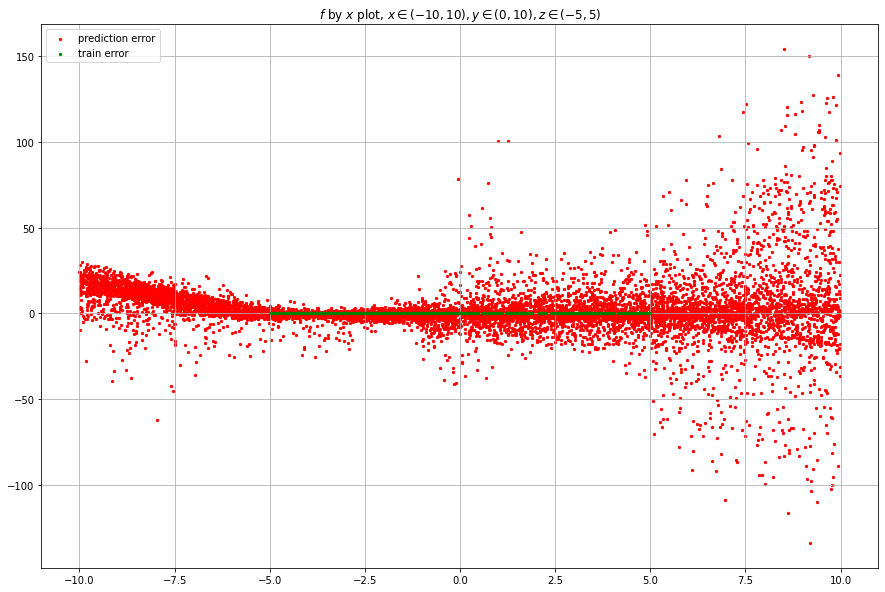

In [95]:
learner.plot_axis(np.random.uniform((-10, 0, -5), (10, 10, 5), (10000, 3)), 0, "$f$ by $x$ plot, $x \\in (-10, 10), y \\in (0, 10), z \\in (-5, 5) $")

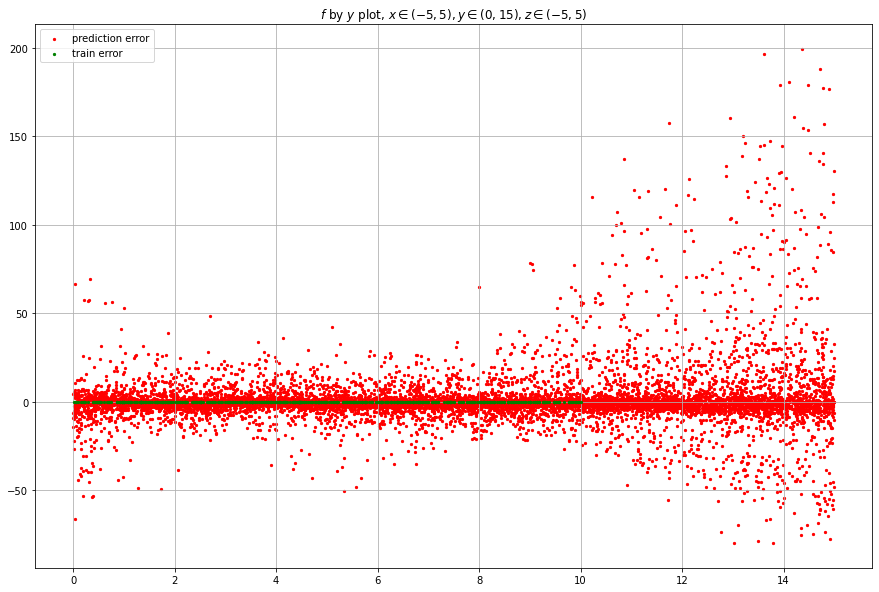

In [96]:
learner.plot_axis(np.random.uniform((-5, 0, -5), (5, 15, 5), (10000, 3)), 1, "$f$ by $y$ plot, $x \\in (-5, 5), y \\in (0, 15), z \\in (-5, 5) $")

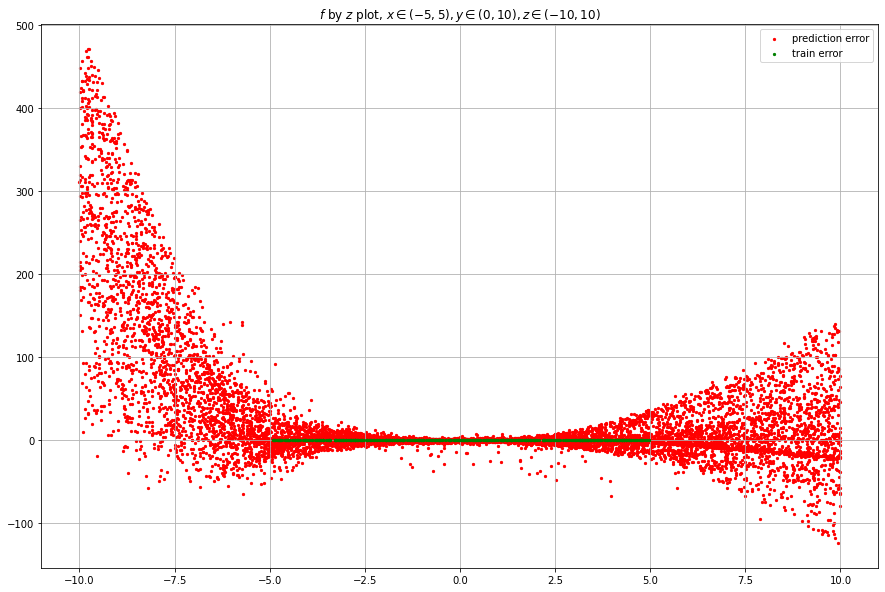

In [97]:
learner.plot_axis(np.random.uniform((-5, 0, -10), (5, 10, 10), (10000, 3)), 2, "$f$ by $z$ plot, $x \\in (-5, 5), y \\in (0, 10), z \\in (-10, 10) $")